## Семинар 15: различные имплементации градиентного бустинга

* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

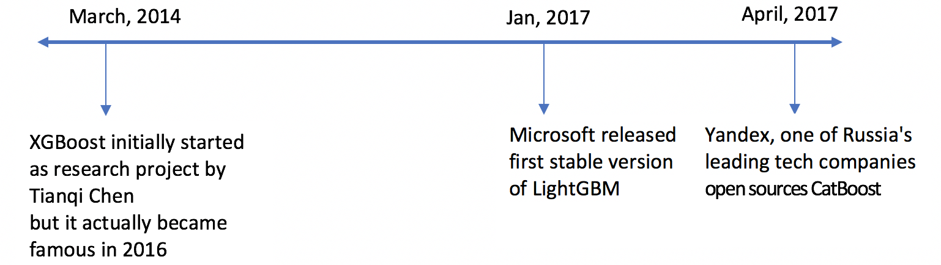

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [ ]:
# !pip install xgboost

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
import matplotlib.pyplot as plt
# %pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Будем решать задачу классификации: по различным характеристикам клиента попытаемся определить, выплатит клиент долг или нет.

In [3]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
len(X_train), len(X_test)

(24365, 10443)

In [4]:
X_train.head()

,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,Loan_Amount_Submitted_Missing,...,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed,ID
0,0.0,250000.0,5.0,23200,2,3,28,1,1,0,...,0,0,0,0,1,0,1,0,0.0,8161
1,0.0,0.0,0.0,25000,0,0,33,1,1,1,...,0,0,1,0,1,1,0,0,0.0,77530
2,0.0,0.0,0.0,95000,3,7,39,1,1,0,...,0,0,1,0,1,1,0,0,0.0,80633
3,0.0,0.0,0.0,29880,5,3,28,0,0,0,...,0,0,0,0,1,0,1,0,0.0,45059
4,4500.0,100000.0,3.0,30000,5,10,26,0,0,0,...,0,0,1,0,1,1,0,0,0.0,54857


Для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры. 

Алгоритм подбора гиперпараметров следующий:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

$(y_i - \hat{y}_i)^2$

In [ ]:
?XGBClassifier

In [5]:
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [6]:
target='Disbursed'
IDcol = 'ID'

In [7]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    23999
 1.0      366
 Name: Disbursed, dtype: int64, 24365)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [8]:
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Начинаем последовательный подбор параметров при большом learning_rate


Model Report
Accuracy : 0.985
AUC Score (Train): 0.887371
AUC Score (Test): 0.835307


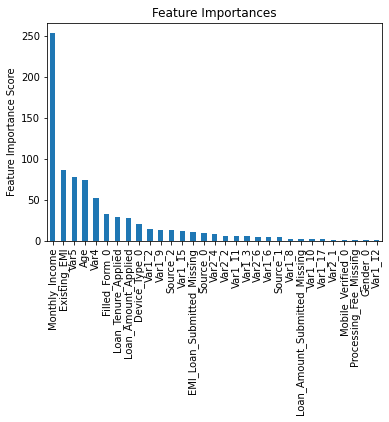

In [9]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [10]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train[predictors],X_train[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8257756892357223)

In [ ]:
list(range(2,7,2))

[2, 4, 6]

In [ ]:
list(range(1,6,2))

[1, 3, 5]

Уточняем предсказание

In [11]:
param_test2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [4, 5, 6]
}

gsearch2 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train[predictors],X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 4}, 0.8275727094238364)

Зафиксируем найденный max_depth и min_child_weight

In [12]:
model_xgb.max_depth = 3 # 5
model_xgb.min_child_weight = 4 # 3

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [13]:
param_test3 = {
    'gamma': np.linspace(0, 1, 4)
}

gsearch3b = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(min_child_weight=4, n_estimators=150,
                                     nthread=-1, seed=27),
             n_jobs=-1,
             param_grid={'gamma': array([0.        , 0.33333333, 0.66666667, 1.        ])},
             scoring='roc_auc')

In [ ]:
np.linspace(0, 1, 4)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [14]:
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 0.6666666666666666}, 0.8277889006971402)

Установите в качестве параметра алгоритма подобранyю gamma и посмотрите как изменилось качество.


Model Report
Accuracy : 0.985
AUC Score (Train): 0.884982
AUC Score (Test): 0.830568


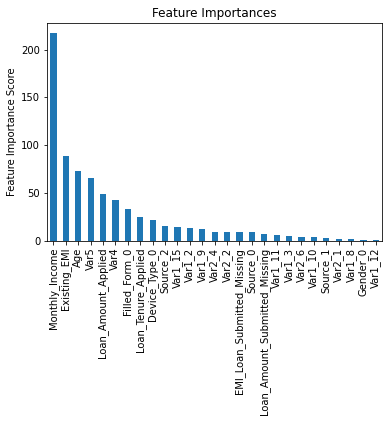

In [15]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

model_xgb.gamma = 0.67 # 1

modelfit(model_xgb, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
?XGBClassifier

In [16]:
param_test4 = {
    'subsample': [0.6,0.7,0.8,0.9,1.],
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.]
}

gsearch4 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test4,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch4.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(gamma=0.67, min_child_weight=4,
                                     n_estimators=150, nthread=-1, seed=27),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [17]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.8282595122389772)

In [18]:
model_xgb.colsample_bytree = 0.7
model_xgb.subsample = 0.8

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [19]:
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test5,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch5.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.7, gamma=0.67,
                                     min_child_weight=4, n_estimators=150,
                                     nthread=-1, seed=27, subsample=0.8),
             n_jobs=-1, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [20]:
gsearch5.best_params_, gsearch4.best_score_

({'reg_alpha': 1e-05}, 0.8282595122389772)

In [21]:
model_xgb.reg_alpha = 1e-05

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.


Model Report
Accuracy : 0.985
AUC Score (Train): 0.885600
AUC Score (Test): 0.831625


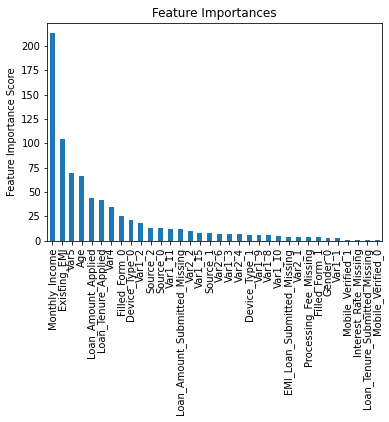

In [22]:
modelfit(model_xgb, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.


Model Report
Accuracy : 0.985
AUC Score (Train): 0.883608
AUC Score (Test): 0.834521


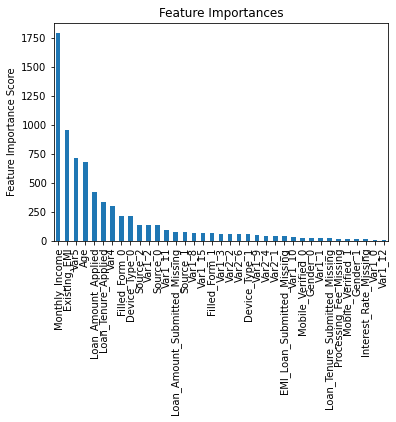

In [23]:
#Your code here
model_xgb.learning_rate = 0.01
model_xgb.n_estimators = 1500

modelfit(model_xgb, X_train, X_test, predictors)

## 2. CatBoost

Оригинальный ноутбук здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг 

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [ ]:
!pip uninstall catboost

Found existing installation: catboost 1.0.6
Uninstalling catboost-1.0.6:
  Would remove:
    /root/.local/etc/jupyter/nbconfig/notebook.d/catboost-widget.json
    /root/.local/lib/python3.7/site-packages/catboost-1.0.6.dist-info/*
    /root/.local/lib/python3.7/site-packages/catboost/*
    /root/.local/share/jupyter/labextensions/catboost-widget/package.json
    /root/.local/share/jupyter/labextensions/catboost-widget/static/138.594e2e2f9fae55d2125b.js
    /root/.local/share/jupyter/labextensions/catboost-widget/static/479.8635cb839b51b24dbe44.js
    /root/.local/share/jupyter/labextensions/catboost-widget/static/479.8635cb839b51b24dbe44.js.LICENSE.txt
    /root/.local/share/jupyter/labextensions/catboost-widget/static/486.c2672c1c6aabd4dcb1c5.js
    /root/.local/share/jupyter/labextensions/catboost-widget/static/486.c2672c1c6aabd4dcb1c5.js.LICENSE.txt
    /root/.local/share/jupyter/labextensions/catboost-widget/static/755.f7277b38a5f70148dece.js
    /root/.local/share/jupyter/labexten

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached catboost-1.0.6-cp37-none-manylinux1_x86_64.whl (76.6 MB)


In [ ]:
import catboost

In [ ]:
#!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# # from matplotlib import pylab as plt
# import matplotlib.pyplot as plt

# # %pylab inline

In [ ]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [ ]:
(train_df, test_df) = catboost.datasets.amazon()

In [ ]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Готовим данные

In [ ]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

In [ ]:
y.value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

Создаем список категориальных фичей

In [ ]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [ ]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Способы создать Pool - объект, содержащий матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [ ]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3: ' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Печать результатов

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 43.7ms	remaining: 394ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 110ms	remaining: 440ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 163ms	remaining: 380ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 203ms	remaining: 305ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 238ms	remaining: 238ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 292ms	remaining: 195ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 315ms	remaining: 135ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 337ms	remaining: 84.2ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 352ms	remaining: 39.1ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 363ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Визуализация метрик

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [ ]:
model1 = CatBoostClassifier(
    learning_rate=0.1,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.1'
)

model2 = CatBoostClassifier(
    learning_rate=0.07,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.07'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost import MetricVisualizer

MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

Оптимальное количество деревьев

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

Кросс-валидация

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

In [ ]:
cv_data.head()

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print(model_with_early_stop.tree_count_)

In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print(model_with_early_stop.tree_count_)

Вычисление метрик качества и выбор порога принятия решения

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

Получение предсказаний

In [ ]:
print(model.predict_proba(X_validation))

In [ ]:
print(model.predict(X_validation))

Последовательные предсказания

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Важность признаков

In [ ]:
model.get_feature_importance(prettified=True)

### Shap values 

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [ ]:
import shap

shap_values = model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(32769, 9)


In [ ]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Сохранение модели

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

Подбор гиперпараметров

In [ ]:
cat = CatBoostClassifier(n_estimators=50)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

In [ ]:
grid_search_result['params']

Визуализация деревьев

In [ ]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

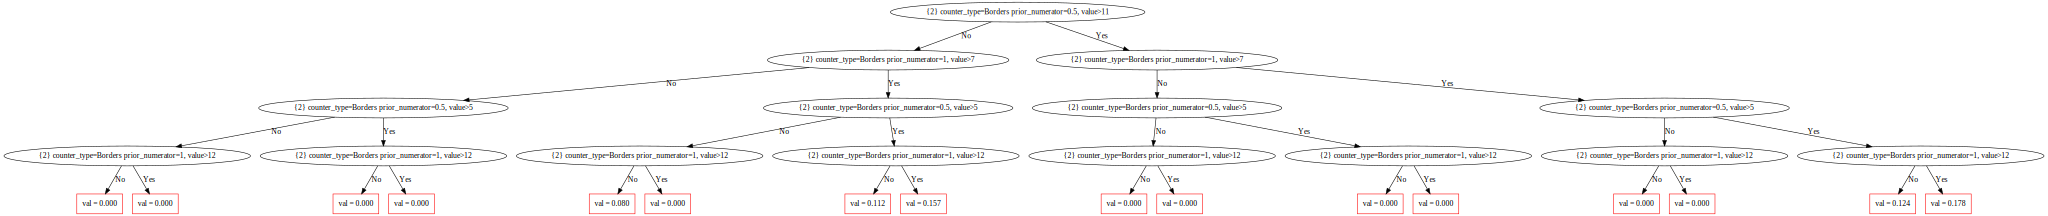

In [ ]:
model.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
#!pip install lightgbm

!conda install lightgbm --y

# For those who strugle with M1/M2 macs:
# !arch -arm64 brew install libomp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

import numpy as np

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=100, random_state=241)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

Обучение

In [ ]:
import lightgbm as lgb

In [ ]:
print('Starting training...')
# train
from lightgbm import LGBMRegressor

gbm = LGBMRegressor(num_leaves=31,
                    learning_rate=0.05,
                    n_estimators=20)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Starting training...
[1]	valid_0's l2: 76.761	valid_0's l1: 6.55152
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 71.5199	valid_0's l1: 6.29855
[3]	valid_0's l2: 67.0386	valid_0's l1: 6.08526
[4]	valid_0's l2: 62.9998	valid_0's l1: 5.88219
[5]	valid_0's l2: 58.889	valid_0's l1: 5.66549
[6]	valid_0's l2: 55.1763	valid_0's l1: 5.45931
[7]	valid_0's l2: 52.2049	valid_0's l1: 5.29116
[8]	valid_0's l2: 49.089	valid_0's l1: 5.10806
[9]	valid_0's l2: 46.2628	valid_0's l1: 4.93583
[10]	valid_0's l2: 44.0623	valid_0's l1: 4.79662
[11]	valid_0's l2: 41.4139	valid_0's l1: 4.62366
[12]	valid_0's l2: 39.5294	valid_0's l1: 4.48798
[13]	valid_0's l2: 37.383	valid_0's l1: 4.32989
[14]	valid_0's l2: 35.4853	valid_0's l1: 4.18449
[15]	valid_0's l2: 34.094	valid_0's l1: 4.07735
[16]	valid_0's l2: 32.4964	valid_0's l1: 3.96772
[17]	valid_0's l2: 31.299	valid_0's l1: 3.8743
[18]	valid_0's l2: 30.0159	valid_0's l1: 3.77696
[19]	valid_0's l2: 28.8212	valid_0's l1: 3.68361
[20

LGBMRegressor(learning_rate=0.05, n_estimators=20)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Можно задать любую (придумать свою, например) метрику качества

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Подбор гиперпараметров

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)